In [20]:
import mdtraj as mda
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from ase import Atoms
from tqdm.notebook import tqdm

data_paths = [
	'./data/dump-surface.lammpstrj',
	'./data/dump-surface-280.lammpstrj',
	'./data/dump-surface-320.lammpstrj',
]
layer_num = 40
min_frame = 0
max_frame = 2000
frame_step = 1
def_num_bins = 100

# Load Data

In [21]:

def load_trajectory(data_path) -> tuple[Atoms, ]:
	traj = read(data_path, index=':')

	indices = list(range(min_frame, min(len(traj), max_frame), frame_step))
	num_frames = len(indices)

	print(f'Total frames: {num_frames}')


In [22]:
# convert to numpy array for easier processing
def fix_H(O : np.ndarray, H : np.ndarray, box : np.ndarray) -> np.ndarray :
	dr = H - O
	for i in range(3) :
		if dr[i] > box[i] / 2 :
			H[i] -= box[i]
		elif dr[i] < -box[i] / 2 :
			H[i] += box[i]
	return H
def to_numpy(traj : list[Atoms], indices : list[int], num_frames : int) -> tuple[np.ndarray, np.ndarray]  :
	A = np.zeros((num_frames, 3, traj[0].get_positions().shape[0] // 3, 3), dtype=np.float64)
	boxes = []

	for idx, i in enumerate(tqdm(indices, desc='Reading frames')):
		frame = traj[i]
		box = traj[0].get_cell()
		box = np.array([box[0][0], box[1][1], box[2][2]], dtype=np.float64)
		positions = frame.get_positions()

		for x in range(positions.shape[0] // 3) :
			O = positions[3*x]
			H1 = positions[3*x + 1]
			H2 = positions[3*x + 2]

			A[idx, 0, x, :] = O
			A[idx, 1, x, :] = fix_H(O, H1, box)
			A[idx, 2, x, :] = fix_H(O, H2, box)

		indices = [i for i in range(A.shape[2])]
		indices = sorted(indices, key=lambda x: A[idx, 0, x, 2])
		indices = np.array(indices, dtype=np.int64)

		A_sorted = np.zeros_like(A[idx, :, :, :])
		for new_x, old_x in enumerate(indices) :
			A_sorted[:, new_x, :] = A[idx, :, old_x, :]
		A[idx] = A_sorted

		boxes.append(box)
	return A, np.array(boxes, dtype=np.float64)

def min_image(dr, box_lengths):
	if dr.ndim == 1 :
		for i in range(3) :
			if dr[i] > box_lengths[i] / 2 :
				dr[i] -= box_lengths[i]
			elif dr[i] < -box_lengths[i] / 2 :
				dr[i] += box_lengths[i]
	else :
		for i in range(3) :
			mask_g = dr[:, i] > box_lengths[i] / 2
			mask_l = dr[:, i] < -box_lengths[i] / 2
			dr[mask_g, i] -= box_lengths[i]
			dr[mask_l, i] += box_lengths[i]
	return dr

def get_layerId(idx, box) :
	return int((idx + box[2] / 2) / box[2] * layer_num)

# 计算氢键

距离 $<3.5$ 任何一个H-O-O 角度小于 $30^{\circ}$ 视为氢键

In [23]:
def chk_hb(O, H1, H2, Os, H1s, H2s, box) -> tuple[np.ndarray, np.ndarray] :
	hb_rad = np.deg2rad(30)

	uH1, uH2 = H1 - O, H2 - O
	uH3, uH4 = Os - H1, Os - H1

	uH1, uH2 = min_image(uH1, box), min_image(uH2, box)
	uH3, uH4 = min_image(uH3, box), min_image(uH4, box)

	n1, n2, n3, n4 = np.linalg.norm(uH1), np.linalg.norm(uH2), np.linalg.norm(uH3, axis=1), np.linalg.norm(uH4, axis=1)

	cos_ang1 = np.dot(uH3, uH1) / (n1 * n3)
	cos_ang2 = np.dot(uH4, uH2) / (n2 * n4)

	ang1 = np.acos(np.clip(cos_ang1, -1.0, 1.0))
	ang2 = np.acos(np.clip(cos_ang2, -1.0, 1.0))

	mask1 = (ang1 < hb_rad) | (ang2 < hb_rad)

	uH1, uH2 = H1s - Os, H2s - Os
	uH3, uH4 = O - H1s, O - H1s

	uH1, uH2 = min_image(uH1, box), min_image(uH2, box)
	uH3, uH4 = min_image(uH3, box), min_image(uH4, box)

	n1, n2, n3, n4 = np.linalg.norm(uH1, axis=1), np.linalg.norm(uH2, axis=1), np.linalg.norm(uH3, axis=1), np.linalg.norm(uH4, axis=1)

	cos_ang1 = np.sum(uH1 * uH3, axis=1) / (n1 * n3)
	cos_ang2 = np.sum(uH2 * uH4, axis=1) / (n2 * n4)

	ang1 = np.acos(np.clip(cos_ang1, -1.0, 1.0))
	ang2 = np.acos(np.clip(cos_ang2, -1.0, 1.0))

	mask2 = (ang1 < hb_rad) | (ang2 < hb_rad)

	return (mask1, mask2)
def calc_hb(A : np.ndarray, boxes : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray] :
	hb_dis = 3.5

	hb_m_cnt = np.zeros((A.shape[0], A.shape[2]))
	hb_layer_cnt = np.zeros((A.shape[0], layer_num))
	m_layer_cnt = np.zeros((A.shape[0], layer_num))

	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating H-bonds')
	for t in range(A.shape[0]) :
		box = boxes[t]
		for x in range(A.shape[2]) :
			O = A[t, 0, x, :]
			H1 = A[t, 1, x, :]
			H2 = A[t, 2, x, :]

			Os = A[t, 0, :, :]
			H1s = A[t, 1, :, :]
			H2s = A[t, 2, :, :]

			dis = np.linalg.norm(min_image(Os - O, box), axis=1)
			mask = dis < hb_dis
			mask[x] = False

			Os = Os[mask]
			H1s = H1s[mask]
			H2s = H2s[mask]

			mask1, mask2 = chk_hb(O, H1, H2, Os, H1s, H2s, box)

			hb_m_cnt[t, x] = np.sum(mask1 | mask2)

			pBar.update(1)
	pBar.close()


	hb_layer_cnt = np.zeros((A.shape[0], layer_num))
	m_layer_cnt = np.zeros((A.shape[0], layer_num))

	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer H-bonds')
	for t in range(hb_m_cnt.shape[0]) :
		box = boxes[t]
		for x in range(hb_m_cnt.shape[1]) :
			pBar.update(1)
			layer = get_layerId(A[t, 0, x, 2], box)
			hb_layer_cnt[t, layer] += hb_m_cnt[t, x]
			m_layer_cnt[t, layer] += 1

	pBar.close()

	hb_layer_cnt /= (m_layer_cnt + 1e-12)

	return hb_m_cnt, hb_layer_cnt, m_layer_cnt

# 和 Z 轴的夹角

In [24]:
# calculate angle of 1/2 * (H1-O + H2-O) with z-axis
def calc_z_angle(A : np.ndarray, boxes : np.ndarray, num_bins : int = def_num_bins) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
	# Initialize an array to store the angles
	z_ang = np.zeros((A.shape[0], A.shape[2]))
	for t in tqdm(range(A.shape[0]), desc='Calculating dipole angles') :
		Os = A[t, 0, :, :]
		H1s = A[t, 1, :, :]
		H2s = A[t, 2, :, :]

		dipole = min_image(Os - H1s, boxes[t]) + min_image(Os - H2s, boxes[t])
		nan_mask = (np.linalg.norm(dipole, axis=1) == 0)
		dipole /= np.linalg.norm(dipole, axis=1, keepdims=True) + 1e-12

		cos_ang = dipole[:, 2]  # z-component
		ang = np.arccos(np.clip(cos_ang, -1.0, 1.0))
		ang[nan_mask] = np.nan
		z_ang[t, :] = ang
		
	z_ang_all = []
	z_O_all = []
	for t in tqdm(range(A.shape[0]), desc='Collecting dipole angles') :
		z_ang_all.append(z_ang[t, :])
		z_mean = A[t, 0, :, 2].mean()
		z_O_all.append(A[t, 0, :, 2] - z_mean)
	
	z_ang_all = np.concatenate(z_ang_all)
	z_O_all = np.concatenate(z_O_all)
	indices = np.argsort(z_O_all)
	z_O_all = z_O_all[indices]
	z_ang_all = z_ang_all[indices]

	# z_ang_layer = np.array([np.nan] * (A.shape[0] * layer_num)).reshape(A.shape[0], layer_num)
	z_ang_layer = np.full_like(np.zeros((A.shape[0], layer_num)), 0, dtype=np.float64)
	m_layer_cnt = np.zeros((A.shape[0], layer_num))
	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer dipole angles')
	for t in range(z_ang.shape[0]) :
		box = boxes[t]
		for x in range(z_ang.shape[1]) :
			pBar.update(1)
			layer = get_layerId(A[t, 0, x, 2], box)
			if z_ang_layer[t, layer] == np.nan:
				z_ang_layer[t, layer] = 0
			z_ang_layer[t, layer] += z_ang[t, x]
			m_layer_cnt[t, layer] += 1
	pBar.close()

	z_ang_layer = z_ang_layer / (m_layer_cnt + 1e-12)

	z_min, z_max = z_O_all.min(), z_O_all.max()
	bin_edges = np.linspace(z_min, z_max, num_bins + 1)
	indices = np.searchsorted(z_O_all, bin_edges)
	bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

	mean_angles = np.full(num_bins, np.nan)

	for i in tqdm(range(num_bins), desc='Calculating mean angles per bin'):
		s, e = indices[i], indices[i + 1]
		if e > s:
			mean_angles[i] = z_ang_all[s : e].mean()
	
	nan_mask = ~np.isnan(mean_angles)
	mean_angles = mean_angles[nan_mask]
	bin_centers = bin_centers[nan_mask]
	
	return z_ang_layer, mean_angles, bin_centers

# 氢键角度平均值

In [25]:
def calc_s_angle(A : np.ndarray, boxes : np.ndarray) -> list[np.ndarray] : 
	s_angle = np.zeros((A.shape[0], A.shape[2]))
	hb_dis = 3.5
	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating solid angles')
	for t in range(A.shape[0]) :
		box = boxes[t]
		for x in range(A.shape[2]) :
			pBar.update(1)
			O = A[t, 0, x, :]
			H1 = A[t, 1, x, :]
			H2 = A[t, 2, x, :]

			Os = A[t, 0, :, :]
			H1s = A[t, 1, :, :]
			H2s = A[t, 2, :, :]
			
			dis = np.linalg.norm(min_image(Os - O, box), axis=1)
			mask = dis < hb_dis
			mask[x] = False

			Os = Os[mask]
			H1s = H1s[mask]
			H2s = H2s[mask]

			mask1, mask2 = chk_hb(O, H1, H2, Os, H1s, H2s, box)

			valid_all = mask1 | mask2
			
			Os = Os[valid_all]

			if Os.shape[0] < 2 :
				s_angle[t, x] = np.nan
				continue
			
			dis = Os - O
			dis = min_image(dis, box)
			us = dis / np.linalg.norm(dis, axis=1, keepdims=True)
			cos_theta = us @ us.T
			theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
			angle_sum = theta.sum() - np.trace(theta)
			avg_angle = angle_sum / (theta.shape[0] * (theta.shape[0] - 1) + 1e-12)
			s_angle[t, x] = avg_angle
			
	pBar.close()
	s_angle_layer = [ [ [] for _ in range(layer_num) ] for _ in range(A.shape[0]) ]
	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer solid angles')
	for t in range(A.shape[0]) :
		box = boxes[t]
		for x in range(A.shape[2]) :
			pBar.update(1)
			if np.isnan(s_angle[t, x]) :
				continue
			layer = get_layerId(A[t, 0, x, 2], box)
			s_angle_layer[t][layer].append(s_angle[t, x])
	pBar.close()
	s_angle_layer_all = [None] * layer_num
	# use scatter to plot the solid angle distribution per layer

	# use scatter to plot the solid angle distribution per layer
	for layer in range(layer_num) :
		values = [ s_angle_layer[t][layer] for t in range(A.shape[0]) ]
		values = np.concatenate(values)
		s_angle_layer_all[layer] = values
	print([len(s_angle_layer_all[layer]) for layer in range(layer_num)])
	return s_angle_layer, s_angle_layer_all

# 悬挂氢

1. 悬挂氢 的 氢氧键 z 轴夹角角度;
2. 所有氢氧键和 z 轴夹角角度;
3. 每一个 BIN 的悬挂氢占比

In [26]:
def calc_dang(A : np.ndarray, boxes : np.ndarray, num_bin : int = def_num_bins) -> \
	tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] :
	"""
	returns :
	- rad_dang_bin : (n, )
	- rad_all_bin : (n, )
	- frac_dang_bin : (n, )
	- z_centers : (n, )

	其中 n<=num_bin，实际的 bin 数量取决于数据分布
	"""
	hb_dis = 3.5
	hb_rad = np.deg2rad(30)
	rad_all = np.zeros((A.shape[0], A.shape[2] * 2))
	dang_all = np.zeros((A.shape[0], A.shape[2] * 2), dtype=bool)

	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating dangling hydrogens')
	for t in range(A.shape[0]) :
		box = boxes[t]
		for x in range(A.shape[2]) :
			pBar.update(1)
			O = A[t, 0, x, :]
			Os = A[t, 0, :, :]
			H1 = A[t, 1, x, :]
			H2 = A[t, 2, x, :]

			v1 = min_image(H1 - O, box)
			v2 = min_image(H2 - O, box)

			n1 = np.linalg.norm(v1)
			n2 = np.linalg.norm(v2)

			cos_ang1 = v1[2] / n1
			cos_ang2 = v2[2] / n2

			rad_all[t, 2*x] = np.arccos(cos_ang1)
			rad_all[t, 2*x + 1] = np.arccos(cos_ang2)

			dis_o = min_image(Os - O, box)
			dis = np.linalg.norm(dis_o, axis=1)
			mask = dis < hb_dis
			mask[x] = False

			Os = Os[mask]
			v3 = min_image(Os - H1, box)
			v4 = min_image(Os - H2, box)

			v3 /= np.linalg.norm(v3, axis=1, keepdims=True)
			v4 /= np.linalg.norm(v4, axis=1, keepdims=True)

			cos_ang1 = np.dot(v3, v1)
			cos_ang2 = np.dot(v4, v2)

			ang1 = np.arccos(np.clip(cos_ang1, -1.0, 1.0))
			ang2 = np.arccos(np.clip(cos_ang2, -1.0, 1.0))


			mask1 = ang1 < hb_rad
			mask2 = ang2 < hb_rad

			dang_all[t, 2*x] = not np.any(mask1)
			dang_all[t, 2*x + 1] = not np.any(mask2)
	
	pBar.close()

	xs : list[np.ndarray] = []
	for t in range(A.shape[0]) :
		z_mean = A[t, 0, :, 2].mean()
		zs : np.ndarray = A[t, 0, :, 2] - z_mean
		xs.append(zs.repeat(2))
	
	xs = np.concatenate(xs)
	rad_all = rad_all.flatten()
	dang_all = dang_all.flatten()

	indices = np.argsort(xs)
	xs = xs[indices]
	rad_all = rad_all[indices]
	dang_all = dang_all[indices]

	z_min, z_max = xs.min(), xs.max()
	bin_edges = np.linspace(z_min, z_max, num_bin + 1)
	indices = np.searchsorted(xs, bin_edges)
	bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

	rad_dang_bin = np.full(num_bin, np.nan)
	rad_all_bin = np.full(num_bin, np.nan)
	frac_dang_bin = np.full(num_bin, np.nan)

	for i in tqdm(range(num_bin), desc='Calculating dangling hydrogen fractions per bin'):
		s, e = indices[i], indices[i + 1]
		if e > s:
			if dang_all[s : e].sum() == 0:
				rad_dang_bin[i] = np.nan
			else :
				rad_dang_bin[i] = rad_all[s : e][dang_all[s : e]].mean()
			rad_all_bin[i] = rad_all[s : e].mean()
			frac_dang_bin[i] = np.sum(dang_all[s : e]) / (e - s)
	
	nan_mask = ~np.isnan(frac_dang_bin)
	rad_dang_bin = rad_dang_bin[nan_mask]
	rad_all_bin = rad_all_bin[nan_mask]
	frac_dang_bin = frac_dang_bin[nan_mask]
	bin_centers = bin_centers[nan_mask]

	return rad_dang_bin, rad_all_bin, frac_dang_bin, bin_centers


# 最远氢键 和 最近未成键 距离差

In [27]:
def calc_dis_diff(A : np.ndarray, boxes : np.ndarray) -> np.ndarray :
	hb_dis = 3.5
	dis_diff = np.zeros((A.shape[0], A.shape[2]))
	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating difference between max hbond distance min no-bond distance')
	for t in range(A.shape[0]) :
		box = boxes[t]
		for x in range(A.shape[2]) :
			pBar.update(1)
			O = A[t, 0, x, :]
			H1 = A[t, 1, x, :]
			H2 = A[t, 2, x, :]
			Os = A[t, 0, :, :]
			H1s = A[t, 1, :, :]
			H2s = A[t, 2, :, :]

			dis = np.linalg.norm(min_image(Os - O, box), axis=1)
			mask = dis < hb_dis
			mask[x] = False

			Os = Os[mask]
			H1s = H1s[mask]
			H2s = H2s[mask]

			no_bond_dis = dis[~mask]
			hbond_dis = dis[mask]

			if hbond_dis.shape[0] == 0 or no_bond_dis.shape[0] == 0 :
				dis_diff[t, x] = np.nan
				continue

			min_no_bond = np.min(no_bond_dis)

			mask1, mask2 = chk_hb(O, H1, H2, Os, H1s, H2s, box)

			if (mask1 | mask2).sum() == 0 : continue

			dis_all = min_image(Os - O, box)
			max_bond = np.max(np.linalg.norm(dis_all[mask1 | mask2]))

			if (~(mask1 | mask2)).sum() != 0 :
				min_no_bond = min(min_no_bond, np.min(np.linalg.norm(dis_all[~(mask1 | mask2)])))
			
			dis_diff[t, x] = max_bond - min_no_bond
			
	pBar.close()

	dis_diff_layer = np.zeros((A.shape[0], layer_num))
	dis_diff_m = np.zeros((A.shape[0], layer_num))
	pBar = tqdm(total=A.shape[0] * A.shape[2], desc='Calculating layer distance differences')
	for t in range(A.shape[0]) :
		box = boxes[t]
		for x in range(A.shape[2]) :
			pBar.update(1)
			layer = get_layerId(A[t, 0, x, 2], box)
			if np.isnan(dis_diff[t, x]) :
				continue
			dis_diff_layer[t, layer] += dis_diff[t, x]
			dis_diff_m[t, layer] += 1
	pBar.close()
	dis_diff_layer_avg = dis_diff_layer / (dis_diff_m + 1e-12)
	
	return dis_diff, dis_diff_layer_avg

Processing file: ./data/dump-surface-280.lammpstrj


Reading frames:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating Z Angle


Calculating dipole angles:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating layer dipole angles:   0%|          | 0/2112000 [00:00<?, ?it/s]

Calculating mean angles per bin:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating S Angle


Calculating dangling hydrogens:   0%|          | 0/2112000 [00:00<?, ?it/s]

Calculating dangling hydrogen fractions per bin:   0%|          | 0/100 [00:00<?, ?it/s]

Processing file: ./data/dump-surface.lammpstrj


Reading frames:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating Z Angle


Calculating dipole angles:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating layer dipole angles:   0%|          | 0/2112000 [00:00<?, ?it/s]

Calculating mean angles per bin:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating S Angle


Calculating dangling hydrogens:   0%|          | 0/2112000 [00:00<?, ?it/s]

Calculating dangling hydrogen fractions per bin:   0%|          | 0/100 [00:00<?, ?it/s]

Processing file: ./data/dump-surface-320.lammpstrj


Reading frames:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating Z Angle


Calculating dipole angles:   0%|          | 0/2000 [00:00<?, ?it/s]

Calculating layer dipole angles:   0%|          | 0/2112000 [00:00<?, ?it/s]

Calculating mean angles per bin:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating S Angle


Calculating dangling hydrogens:   0%|          | 0/2112000 [00:00<?, ?it/s]

Calculating dangling hydrogen fractions per bin:   0%|          | 0/100 [00:00<?, ?it/s]

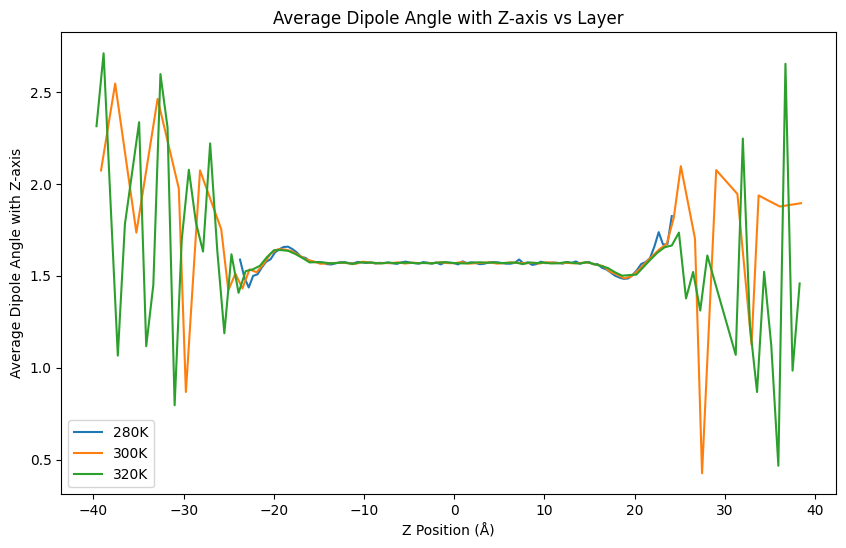

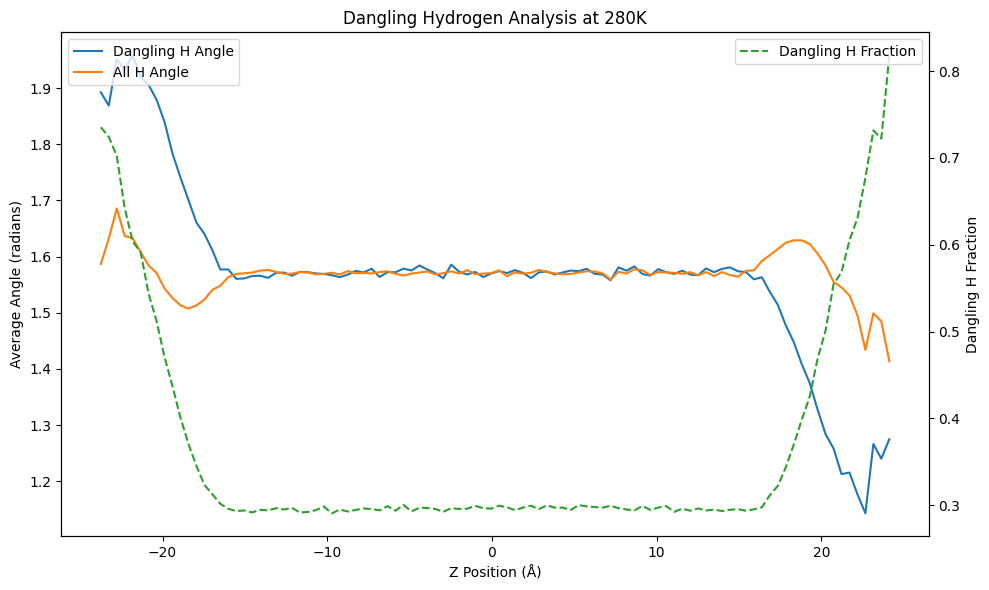

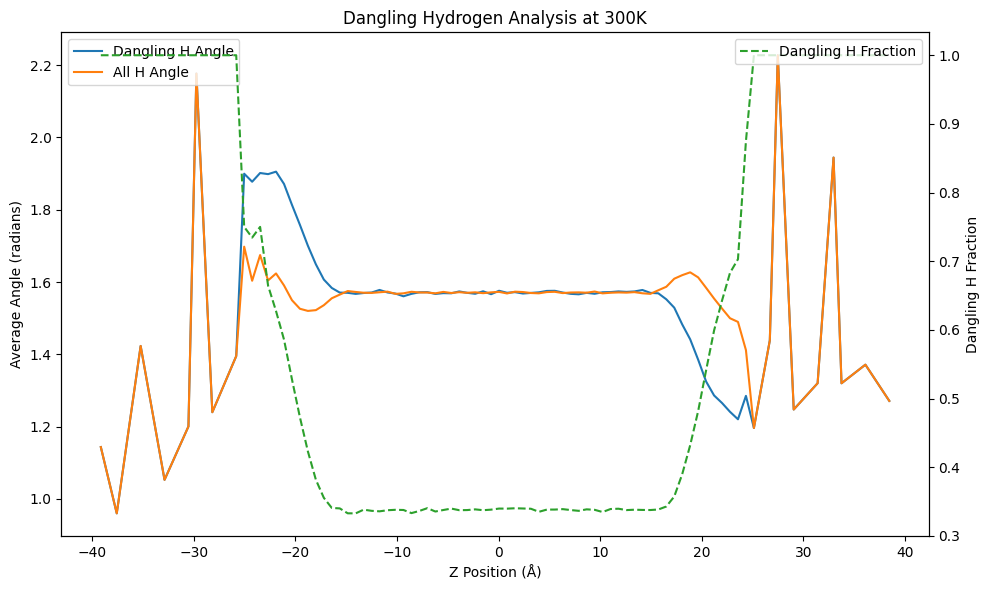

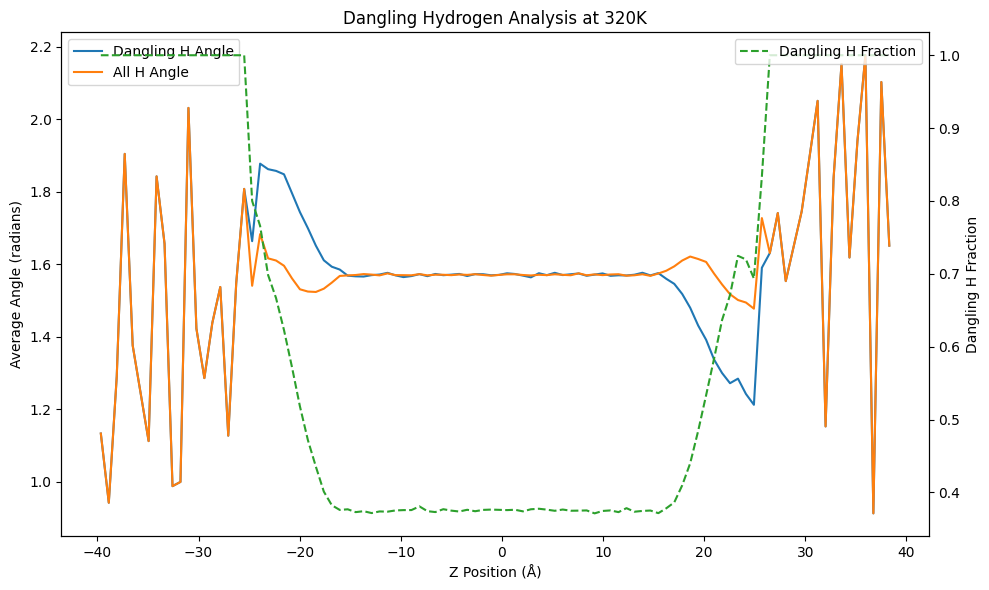

In [28]:
def handle_file(file_path : str) -> None :
	print(f'Processing file: {file_path}')
	traj = read(file_path, index=':')

	indices = list(range(min_frame, min(len(traj), max_frame), frame_step))
	num_frames = len(indices)

	A, boxes = to_numpy(traj, indices, num_frames)

	# print('Calculating HB')
	# _, hb_layer_cnt, _ = calc_hb(A, boxes)
	# print('Calculating Distance Difference')
	# _, dis_diff_layer_avg = calc_dis_diff(A, boxes)
	print('Calculating Z Angle')
	_, z_ang_bin, z_centers = calc_z_angle(A, boxes)
	print('Calculating S Angle')
	# _, s_ang_layer = calc_s_angle(A, boxes)
	# print('Calculating Dangling Hydrogen Angle')
	rad_dang_bin, rad_all_bin, frac_dang_bin, bin_centers = calc_dang(A, boxes)
	
	return {
		# "hb": hb_layer_cnt,
		# "dis_diff": dis_diff_layer_avg,
		"z_ang": (z_ang_bin, z_centers),
		# "s_ang": s_ang_layer,
		"dang": (rad_dang_bin, rad_all_bin, frac_dang_bin, bin_centers),
	}

res_280 = handle_file('./data/dump-surface-280.lammpstrj')
res_300 = handle_file('./data/dump-surface.lammpstrj')
res_320 = handle_file('./data/dump-surface-320.lammpstrj')

# # plot HB
# plt.figure(figsize=(10, 6))
# plt.plot(np.mean(res_280['hb'], axis=0), label='280K')
# plt.plot(np.mean(res_300['hb'], axis=0), label='300K')
# plt.plot(np.mean(res_320['hb'], axis=0), label='320K')
# plt.xlabel('Layer')
# plt.ylabel('Average H-Bonds per Molecule')
# plt.title('Average H-Bonds per Molecule vs Layer')
# plt.legend()

# plot z_angle
plt.figure(figsize=(10, 6))
plt.plot(res_280['z_ang'][1], res_280['z_ang'][0], label='280K')
plt.plot(res_300['z_ang'][1], res_300['z_ang'][0], label='300K')
plt.plot(res_320['z_ang'][1], res_320['z_ang'][0], label='320K')
plt.ylabel('Average Dipole Angle with Z-axis')
plt.xlabel('Z Position (Å)')
plt.title('Average Dipole Angle with Z-axis vs Layer')
plt.legend()

# plot scatter of s_angle
# plt.figure(figsize=(15, 6))
# def scatter_s_angle(res : dict, title : str) :
# 	for layer in range(layer_num) :
# 		if len(res['s_ang'][layer]) == 0 :
# 			continue
# 		xs = np.full_like(res['s_ang'][layer], layer) + np.random.uniform(-0.3, 0.3, size=res['s_ang'][layer].shape)
# 		plt.scatter(xs, res['s_ang'][layer], alpha=max(0.1, 1 / xs.shape[0]), s=0.01)
# 	plt.xlabel('Layer')
# 	plt.ylabel('Solid Angle (radians)')
# 	plt.title(f'Solid Angle Distribution per Layer at {title}')
# # plt.subplot(1, 3, 1)
# # scatter_s_angle(res_280, '280K')
# # plt.subplot(1, 3, 2)
# scatter_s_angle(res_300, '300K')
# # plt.subplot(1, 3, 3)
# # scatter_s_angle(res_320, '320K')
# plt.tight_layout()
# plt.show()

# # plot dis_diff
# plt.figure(figsize=(10, 6))
# plt.plot(np.mean(res_280['dis_diff'], axis=0), label='280K')
# plt.plot(np.mean(res_300['dis_diff'], axis=0), label='300K')
# plt.plot(np.mean(res_320['dis_diff'], axis=0), label='320K')
# plt.xlim(layer_num//4, layer_num*3//4)
# plt.ylim(np.min(res_280['dis_diff'][:, layer_num//4:layer_num*3//4]) - 0.1,
# 		 np.max(res_280['dis_diff'][:, layer_num//4:layer_num*3//4]) + 0.1)
# plt.xlabel('Layer')
# plt.ylabel('Average Distance Difference (Å)')
# plt.title('Average Distance Difference vs Layer')
# plt.legend()
# plt.show()

def plot_dang(res : dict, title : str) :
	rad_dang, rad_all, frac_dang, bin_centers = res['dang']
	fig, ax1 = plt.subplots(figsize=(10, 6))
	
	mask_dang = ~np.isnan(rad_dang)
	mask_all = ~np.isnan(rad_all)
	mask_frag = ~np.isnan(frac_dang)

	mask = mask_dang & mask_all & mask_frag

	ax1.plot(bin_centers[mask], rad_dang[mask], color='tab:blue', label='Dangling H Angle')
	ax1.plot(bin_centers[mask], rad_all[mask], color='tab:orange', label='All H Angle')
	ax1.set_xlabel('Z Position (Å)')
	ax1.set_ylabel('Average Angle (radians)')
	ax1.legend(loc='upper left')

	ax2 = ax1.twinx()
	ax2.plot(bin_centers[mask], frac_dang[mask], color='tab:green', label='Dangling H Fraction', linestyle='--')
	ax2.set_ylabel('Dangling H Fraction')
	ax2.legend(loc='upper right')

	plt.title(f'Dangling Hydrogen Analysis at {title}')
	fig.tight_layout()
	plt.show()

plot_dang(res_280, '280K')
plot_dang(res_300, '300K')
plot_dang(res_320, '320K')